# LANL Notebook

Link to competition and dataset: https://www.kaggle.com/c/LANL-Earthquake-Prediction

Anaysis: https://www.kaggle.com/jsaguiar/seismic-data-exploration


## The Dataset
The training dataset has 2 columns (x, y), representing a single, continuous seismic signal.  x is the signal value, and y is the time-to-next-earthquake. The test data consists of segments of seismic signals (x values), and for each signal point in a segment, a time-to-next-earthquake (y) must be predicted by a machine learning model.

The dataset is large with over 600 million data points in the training signal (9 GB in csv format) and working with it will prove to be challenging (loading, visualizing, training models etc.).


## Useful Ideas

1. Downsampling to reduce dataset size:
> There are ways to do this without aliasing error (or minimal aliasing error). See the [Wiki article](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)) (short).


2. Noise filtering and other signal enhancements:
> The signal *may* be noisy. Any good filters (especially those used in the seismic domain) will improve our model accuracy.


3. Feature engineering: the raw signal maybe 'too raw' for the RNN to learn useful/ predictive patterns. We may have to engineer features.

    3.1. Feature detecting filters
> Features in signals are usually detected by filters (a filter is defined by its kernel: the impulse response). There may be feature detecting filters already used in the seismic analysis domain. Eg: filters to detect the presence of a peak.

    3.2. Engineering other features
> We can engineering other features such as: does_peak_exist_in_this_window, time_since_last_peak, or other signals derived from the original such as first_derivative, second_derivative, Fourier transform (DFT) of the window, moving_average_smoothed, etc.
    
    3.3. Map data to higher dimension, e.g. using Kernels


4. Automating feature engineering via convolutional nets (CNN)
> CNNs essentially learn the kernels of filters as part of the neural network. We can have some CNN layers before the LSTM layers and see if that works.


5. I checked some of the test files and it seems that the peaks are absent. Hence, I stongly recommend completely eliminating the peaks before training the RNN. Peaks will be considered outliers.


6. On the side, we will briefly try a different model, at least to answer the question "Did you try any other models?"

In [1]:
import numpy as np
import pandas as pd
import time, os

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# To visualize the RNN network
from keras.utils.vis_utils import plot_model
import pydot

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'   # Disable GPU as it appears to be slower than CPU (to enable GPU, comment out this line and restart the kernel)

device_name = tf.test.gpu_device_name()

if device_name:
    print('GPU device found: {}. Using GPU'.format(device_name))
else:
    print("GPU device not found. Using CPU")
    #raise SystemError('GPU device not found')   # Stop the program if GPU is unavailabile: disabled for now

GPU device found: /device:GPU:0. Using GPU


In [4]:
#Data was convereted from CSV to HDF then truncated
hdf_key = 'my_key'

# Change the following to point to proper local paths
truncated_train_hdf_file = '../LANL-Earthquake-Prediction/truncated_train_hdf.h5' 
validation_hdf_file = '../LANL-Earthquake-Prediction/validation_hdf.h5'
test_hdf_file = '../LANL-Earthquake-Prediction/test_hdf.h5'

In [5]:
# Tunable parameters relating to the operation of the algorithm

# Data preprocessing
scaling_type = 'None'   # Supports: None, StandardScaler, MinMaxScaler

# LSTM network architecture
time_steps = 100
rnn_layer_units = [50, 50, 50]   # The length of this list = no. of hidden layers
rnn_layer_dropout_rate = [0.2, 0.2, 0]   # Dropout rate for each layer (0 for no dropout)

# Training
epochs = 5
batch_size = 64

# Some checks to ensure the parameters are valid
assert len(rnn_layer_units) == len(rnn_layer_dropout_rate)

In [6]:
def read_hdf(filename, key):
    t0 = time.time()
    print('Reading HDF dataset {}'.format(filename))

    dataset_df = pd.read_hdf(filename, key=key)

    print('Reading complete. time_to_read={:.2f} seconds'.format(time.time() - t0))

    return dataset_df  # This is a Pandas DataFrame

In [7]:
def print_info(df):
    print("Dataset shape = {}".format(df.shape))
    df.info(memory_usage='deep')    # Some info about the dataset (memory usage etc.)

    pd.set_option("display.precision", 15)  # Show more decimals
    print(df.head())

    # print(df.acoustic_data.describe())  # Some stats; can take time if dataset is large


def truncate_dataset(df, num_rows_to_keep):
    print('Truncating the dataset. num_rows_to_keep={}'.format(num_rows_to_keep))
    trunc_df = df[:num_rows_to_keep]
    print('Truncating complete. trunc_df.shape={}'.format(trunc_df.shape))
    return trunc_df

In [8]:
def plot_series(df):
    print('Plotting series')
    t0 = time.time()
    
    fig, ax1 = plt.subplots()

    color = 'tab:orange'
    ax1.set_xlabel('time (#points)')
    ax1.set_ylabel('seismic_signal', color=color)
    ax1.plot(df.acoustic_data, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('time_to_earthquake', color=color)  # we already handled the x-label with ax1
    ax2.plot(df.time_to_failure, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('Plotting complete. time_to_plot={:.2f} seconds'.format(time.time() - t0))

In [9]:
def plot_training_history(history):
    plt.figure()
    plt.title("Training history")
    
    plt.plot(history.history['loss'], label='training_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='validation_loss')
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')

## Import truncated Data from hdf files
### 3 sets: train, validation, test. Print basic stats about them and plot them

In [10]:
train_df = read_hdf(truncated_train_hdf_file, hdf_key)
valid_df = read_hdf(validation_hdf_file, hdf_key)
test_df = read_hdf(test_hdf_file, hdf_key)

Reading HDF dataset ../LANL-Earthquake-Prediction/truncated_train_hdf.h5
Reading complete. time_to_read=5.86 seconds
Reading HDF dataset ../LANL-Earthquake-Prediction/validation_hdf.h5
Reading complete. time_to_read=3.40 seconds
Reading HDF dataset ../LANL-Earthquake-Prediction/test_hdf.h5
Reading complete. time_to_read=1.17 seconds


In [ ]:
print_info(train_df)
plot_series(train_df) # This is time and memory consuming. Do not run this cell unless necessary

In [ ]:
print_info(valid_df)
plot_series(valid_df) # This is time and memory consuming. Do not run this cell unless necessary

In [ ]:
print_info(test_df)
plot_series(test_df) # This is time and memory consuming. Do not run this cell unless necessary

# Understanding Data

## Domain Perspective

https://www.youtube.com/watch?v=T0AEtX-uPLA
- Earthquakes occur when two parts of the earth suddenly move in relation to each other
- Earthequake originates at a point in earth called focus and spreads up to the surface at a point called Epicenter.
- A seismograph detects and records seismic waves. \n",
- Types of Seismic waves include:  Pressure (or Primary) Waves (P-Waves), Shear (or Secondary) Waves (S-Waves) and Surface Waves. P-Waves and S-Waves are both Body waves.

https://courses.lumenlearning.com/geophysical/chapter/earthquake-prediction/
- Predciting when an earthquake will occur is more difficult than predicting where it will occur.
- Sometimes (not always) earthquakes occur few seconds to few weeks after foreshocks.

https://en.wikipedia.org/wiki/P-wave
- P-Wave travel faster and hence are the first waves to reach sesimograph. They propagate through gases, liguids or solids. \n",
- S-Waves are attenuated by liquids.\n",
- P-Waves are non-destructive, while both S-Waves and Surfcae Waves are destructive. \n",
- Earthquake warning is possible if P-Waves are detected. Advanced warning time is dependent on the delay beween the arrival of P-wave and the arrival of the first destructive waves. This delay is a function of how deep the focus is, nature of earth layers and others. It ranges from few seconds to 90 seconds. Ground vibrations resulting from truck movement and contruction activitoes on earth shall be rejected for accurate detection of P-waves.

https://www.bgs.ac.uk/discoveringGeology/hazards/earthquakes/

## Statistical Perspective

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

We need to test data for random-walk/stochasiticity, e.g. correlation tests on both signal (f) and (df), covariance test?!



In [19]:
train_df.max()

acoustic_data      5444.0000
time_to_failure      14.1806
dtype: float64

In [20]:
train_df.min()

acoustic_data     -4621.000000
time_to_failure       0.000695
dtype: float64

# Recurrent Neural Network - LSTM

## Part 1 - Data Preprocessing

Training will be performed on downsampled dataset which consists of  3475  examples out of the original number of training examples which is  139000000
Plotting series


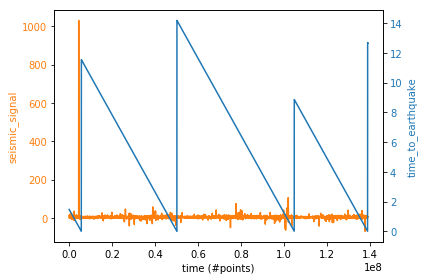

Plotting complete. time_to_plot=0.21 seconds


In [11]:
# Importing the training set
"""Temporary: we downsample the training datatset to reduce time!"""
down_sample=40000
dataset_train = train_df.iloc[::down_sample,:]
training_set = dataset_train.iloc[:, 0:2].values
print("Training will be performed on downsampled dataset which consists of ",dataset_train.shape[0],
      " examples out of the original number of training examples which is ", train_df.shape[0])

plot_series(dataset_train)

In [22]:
dataset_train.info()
dataset_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3475 entries, 0 to 138960000
Data columns (total 2 columns):
acoustic_data      3475 non-null int16
time_to_failure    3475 non-null float64
dtypes: float64(1), int16(1)
memory usage: 61.1 KB


,acoustic_data,time_to_failure
0,12,1.469100
40000,8,1.459597
80000,-1,1.448898
120000,4,1.438299
160000,9,1.427600


In [12]:
# Feature Scaling
if scaling_type == 'None':
    training_set_scaled = training_set
else:
    if scaling_type == 'MinMaxScaler':
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif scaling_type == 'StandardScaler':
        scaler = StandardScaler()
    
    print('Scaling the training set. scaling_type={}'.format(scaling_type))
    t0 = time.time()

    signal_scaled = scaler.fit_transform(training_set[:,0].reshape(-1,1))

    training_set_scaled = training_set.copy()   # May not be necessary
    training_set_scaled[:,0] = signal_scaled.reshape(-1)

    print('Scaling complete. time_to_scale={:.2f} seconds'.format(time.time() - t0))

In [13]:
# Creating the training dataset (X_train and y_train) 
# X_train is a numpy array with some no. of examples. Each example is a seismic signal window of length time_steps
# y_train has the same no. of examples. Each example is the time_to_eq value that corresponds to the last element of seismic signal window (just 1 value)

# ToDo:
# Draw a diagram here illustrating how this input is prepared.
# Write an equation for no. of examples as a function of (training_signal_length, time_steps, stride)

X_train = []
y_train = []
    
for i in range (time_steps, training_set_scaled.shape[0]): 
    X_train.append (training_set_scaled[i - time_steps:i, 0])
    y_train.append (training_set_scaled[i, 1])
X_train, y_train = np.array (X_train), np.array (y_train)

# Reshaping since RNN accepts 3d input
X_train = np.reshape (X_train, (X_train.shape[0], X_train.shape[1], 1))
print ("The 3d shape necessary for RNN's input is ", X_train.shape, " . Note how the number of examples is reduced by the defined time steps, i.e. ", time_steps)

assert X_train.shape[1] == time_steps

The 3d shape necessary for RNN's input is  (3375, 100, 1)  . Note how the number of examples is reduced by the defined time steps, i.e.  100


In [16]:
#Check
print(training_set_scaled[99,0], " ", training_set_scaled[100,1])
print(X_train[0,99,0]," ", y_train[0])

7.0   0.43069744882
7.0   0.43069744882


## Part 2 - Building the RNN

In [14]:
# Initialising the RNN
regressor = Sequential ()

# Adding the hidden layers as given in the parameters

for i, (units, dropout_rate) in enumerate(zip(rnn_layer_units, rnn_layer_dropout_rate)):
    # Common args for all layers
    input_shape = (None,)
    return_sequences = True
    
    # Set special args for first and last layer
    if i == 0:  # First hidden layer
        input_shape = (time_steps, 1)
    if i == len(rnn_layer_units) - 1:   # Last hidden layer
        return_sequences = False
        
    regressor.add(LSTM(units=units, return_sequences=return_sequences, input_shape=input_shape))
    regressor.add (Dropout(dropout_rate))

# Adding the output layer
regressor.add (Dense (units=1))

# Compiling the RNN
regressor.compile (optimizer='adam', loss='mean_squared_error')
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total para

## Part 3 - Training the RNN

In [15]:
print('Training the RNN with the training set')
t0 = time.time()

#with tf.device('/cpu:0'):

history = regressor.fit (X_train, y_train, epochs=epochs, batch_size=batch_size)

time_to_train = time.time() - t0
print('Training complete. time_to_train={:.2f} seconds ({:.2f} minutes)'.format(time_to_train, time_to_train/60))

Training the RNN with the training set
Epoch 1/5
3375/3375 [==============================] - 29s 9ms/step - loss: 20.5564
Epoch 2/5
3375/3375 [==============================] - 26s 8ms/step - loss: 13.6363
Epoch 3/5
3375/3375 [==============================] - 26s 8ms/step - loss: 11.2424
Epoch 4/5
3375/3375 [==============================] - 26s 8ms/step - loss: 8.6524
Epoch 5/5
3375/3375 [==============================] - 26s 8ms/step - loss: 8.2509
Training complete. time_to_train=133.59 seconds (2.23 minutes)


RNN plot saved to rnn_plot.png


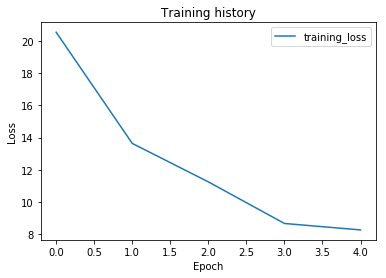

In [16]:
plot_training_history(history)
plot_model(regressor, to_file='rnn_plot.png', show_shapes=True, show_layer_names=True)
print('RNN plot saved to rnn_plot.png')

## Part 4 - Making the predictions and visualising the results

In [17]:
# Import validation set
"""Temporary: we downsample the testing datatset to reduce time!"""
dataset_test = valid_df.iloc[::down_sample,:]
real_time = dataset_test.iloc[:,1].values
print("Validation will be performed on truncated dataset which consists of ",dataset_test.shape[0],
      " examples out of the original number of training examples which is ", valid_df.shape[0])

Validation will be performed on truncated dataset which consists of  2000  examples out of the original number of training examples which is  80000000


In [18]:
dataset_test.info()
dataset_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 139000000 to 218960000
Data columns (total 2 columns):
acoustic_data      2000 non-null int16
time_to_failure    2000 non-null float64
dtypes: float64(1), int16(1)
memory usage: 35.2 KB


,acoustic_data,time_to_failure
139000000,5,12.635498
139040000,10,12.624899
139080000,4,12.614200
139120000,8,12.604696
139160000,7,12.593997


In [19]:
#Because we have time_steps time steps and we we want to predict the first entry of time_to_failure in the validation set, we have to look back time_steps samples. 
#Hence, we get these time_steps past samples from the training set. This is why we first concatenate both training and validation. This step may be omitted if we just need to predict one value
#for the whole test set (such as in the provided test files where one value is only needed so we can look back in the same data provided ) 
dataset_total = pd.concat((dataset_train['acoustic_data'], dataset_test['acoustic_data']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_steps:].values
inputs = inputs.reshape(-1,1)

# Feature Scaling
if scaling_type == 'None':
    inputs_scaled=inputs
else:
    print('Scaling the inputs set. scaling_type={}'.format(scaling_type))
    t0 = time.time()
    inputs_scaled = scaler.transform(inputs) 
    print('Scaling complete. time_to_scale={:.2f} seconds'.format(time.time() - t0))

inputs_scaled.shape # So we end up with input size = size of validation set + time_steps

(2100, 1)

In [20]:
X_test = []

for i in range(time_steps, inputs_scaled.shape[0]):
    X_test.append(inputs_scaled[i-time_steps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(2000, 100, 1)

In [21]:
print('Predicting using the trained RNN')
t0 = time.time()
predicted_time = regressor.predict(X_test)
#predicted_time = sc.inverse_transform(predicted_time)
print('Predicting complete. time_to_predict={:.2f} seconds'.format(time.time() - t0))

Predicting using the trained RNN
Predicting complete. time_to_predict=13.79 seconds


In [24]:
prediction = pd.DataFrame(predicted_time)
prediction.to_csv(r'prediction.csv')
print('Predictions saved to prediction.csv')

Predictions saved to prediction.csv


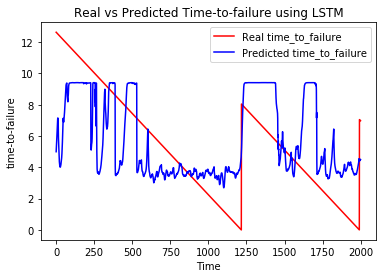

In [25]:
# Visualising the results
plt.plot(real_time, color = 'red', label = 'Real time_to_failure')
plt.plot(predicted_time, color = 'blue', label = 'Predicted time_to_failure')
plt.title('Real vs Predicted Time-to-failure using LSTM')
plt.xlabel('Time')
plt.ylabel('time-to-failure')
plt.legend()
plt.show()